In [250]:
# Importanweisungen

import numpy as np
import statistics as stat
import scipy as sci
import scipy.fftpack
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
from matplotlib import colors as mcolors
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as umath
unv=unp.nominal_values
usd=unp.std_devs

In [251]:
# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 14
fig_labelsize = 12
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#colors

In [252]:
# mathe Funktionen

def mean(n):
    # find the mean value and add uncertainties
    k = np.mean(n)
    err = stat.variance(unv(n))
    return unc.ufloat(unv(k), math.sqrt(usd(k)**2 + err))

def fft(y):
    N = len(y)
    fft = scipy.fftpack.fft(y)
    return 2 * abs(fft[:N//2]) / N

In [253]:
# allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x 
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * np.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

def gauss(x, x0, A, d, y0):
    return A * np.exp(-(x - x0)**2 / 2 / d**2) + y0

def exponential(x, c, y0):
    return np.exp(c * x) * y0

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit 

# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

In [254]:
# gibt Daten fuer LaTeX bereitgestellt aus

def latex_printValue(val, file):
    if hasattr(val, "__iter__"):
        i = 1
        for v in val:
            latex_printValue(v, file+"_"+str(i))
            i += 1
    else:
        f = open('data/%s.txt' % file, 'w')
        f.write(str(val).replace('/', '').replace('(', '').replace)
        f.close()

In [255]:
# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin 
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad

In [256]:
# import der messwerte

unc_freq = 0.005 / 2 / np.sqrt(3) # digital abstand frequenzmessung
unc_MTF = 1e-4 / 2 / np.sqrt(3) # digital abstand frequenzmessung
unc_pixel = 5 / 2 / np.sqrt(3) # digital pixelanzahl
unc_grau = 5 / 2 / np.sqrt(3) # digital graustufen
unc_grey = 1e-2 / 2 / np.sqrt(3) # digital intensitaet grey-value
unc_time = 0.01 # percent

pxratio = unc.ufloat(1, 0.05) * 3 / 41

def converter(data):
    try:
        return float(s if len(s) > 0 else 0)
    except:
        return data
        
con = {}
for i in range(50):
    con[i] = converter

kStufen = [18,28,40,56,80,110,160,220]
kantekFREQ = []
for k in kStufen:
    data = np.loadtxt("messung/auswertung/blendenstufen/kante_k%i_FREQ.xls"%k, skiprows = 1, delimiter = "\t")
    kantekFREQ.append((unp.uarray(data[:,0], unc_freq), unp.uarray(data[:,1], unc_MTF)))

blende = ["375","750","1500","Ohne"]
line = ["1","2","3","4"]
linien = []
for b in blende:
    linie = []
    for l in line:
        data = np.loadtxt("messung/auswertung/einzelblenden/linien%s_%s.xls"%(b,l), skiprows = 1, delimiter = "\t")
        linie.append((unp.uarray(data[:,0], unc_pixel), unp.uarray(data[:,1], unc_grau)))
    linien.append(linie)
    
sterne = ["klein", "gross"]
sternData = []
for stern in sterne:
    sternDat = []
    for blend in blende:
        data1 = np.loadtxt("messung/auswertung/einzelblenden/%s%sWHITE.xls"%(stern,blend), skiprows = 1, delimiter = "\t")
        data2 = np.loadtxt("messung/auswertung/einzelblenden/%s%sBLACK.xls"%(stern,blend), skiprows = 1, delimiter = "\t")
        l = min(len(data1), len(data2))
        sternDat.append((unp.uarray(data1[0:l,0], unc_pixel), unp.uarray(data1[0:l,1], unc_grau)-unp.uarray(data2[0:l,1], unc_grau)))
    sternData.append(sternDat)

mtfKante = []
for blend in blende:
    data = np.loadtxt("messung/auswertung/MTFKante/kante%sFREQ.xls"%(blend), skiprows = 1, delimiter = "\t")
    mtfKante.append((unp.uarray(data[:,0], unc_freq), unp.uarray(data[:,1], unc_MTF)))
    
data = np.loadtxt("messung/zeiten.csv", skiprows = 2, delimiter = ",")
zeitvergleich = (["Ohne", "150mm", "75mm", "37,5mm", "Loch"], unp.uarray(data, np.array(data) * unc_time))

In [257]:
# Rechnung MTF 1/2

kHalbe = []
for (k, data)  in zip(kStufen, kantekFREQ):
    for (x,y) in zip(data[0], data[1]):
        if (y >= 0.5):
            d = x
    kHalbe.append(d)

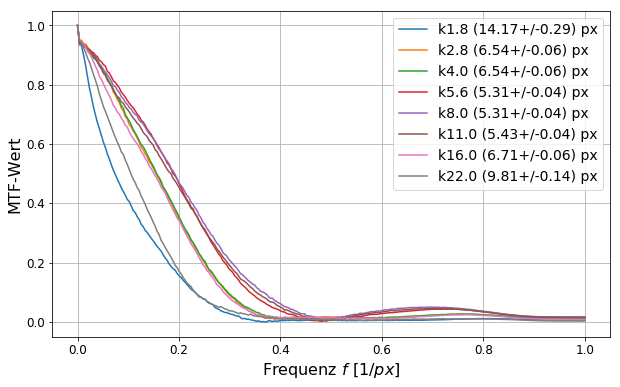

In [271]:
# Diagramm kStufen

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

for (k, data, kH)  in zip(kStufen, kantekFREQ, kHalbe):
    xdata, ydata = data
    plt.plot(unv(xdata), unv(ydata), label='k%s (%s) px'%(k/10, 1/kH))
    
# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Frequenz $f$ [$1/px$]", {'fontsize':fig_legendsize+2})
plt.ylabel("MTF-Wert", {'fontsize': fig_legendsize+2})
#plt.yticks([])
plt.savefig("data/kStufen.pdf")
plt.show()

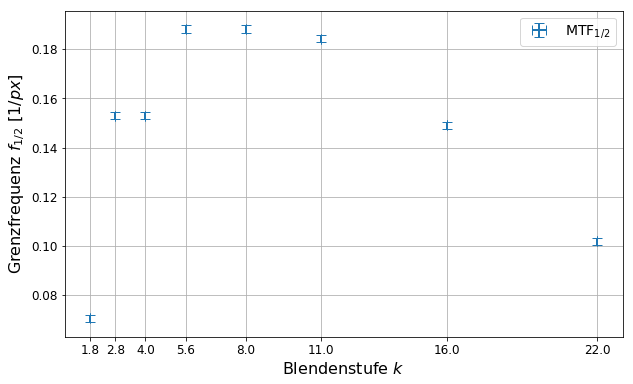

In [259]:
# Diagramm MTF 1/2

fig=plt.figure(figsize=fig_size)
ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

#xdata = np.linspace(0, 25)
#plt.plot(xdata, unv(gerade(xdata, *kHalbeParam)), label='Linear Fit $B=m I$\n$m = (%s)$mT/A%s' % tuple(kHalbeParam))

#color = next(ax._get_lines.prop_cycler)['color']
xdata, ydata = kStufen, kHalbe
plt.errorbar(unv(xdata)/10,unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, label='MTF$_{1/2}$')

#xdata, ydata = lamb2, unp.uarray([0.5]*8, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, color='yellow', label='Na-D-Linie 2')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Blendenstufe $k$", {'fontsize':fig_legendsize+2})
plt.ylabel("Grenzfrequenz $f_{1/2}$ [$1/px$]", {'fontsize': fig_legendsize+2})
plt.xticks([k/10 for k in kStufen])
plt.savefig("data/kHalbe.pdf")
plt.show()

In [260]:
# Rechnung FFT-Linien

N = 1000
x = np.linspace(0,1,N)
y = unp.sin(2*math.pi*20*x) + unp.sin(2*math.pi * 50*x)
ffty = fft(y)

fftLinien = []
for linie in linien:
    fftLinie = []
    for x,y in linie:
        #x, y = [l[i][0] for i in range(len(l))], [l[i][1] for i in range(len(l))]
        #fftVal = fft(l)
        #print(fftVal)
        fftLinie.append(fft(unv(y)))
    fftLinien.append(fftLinie)
#fftLinien

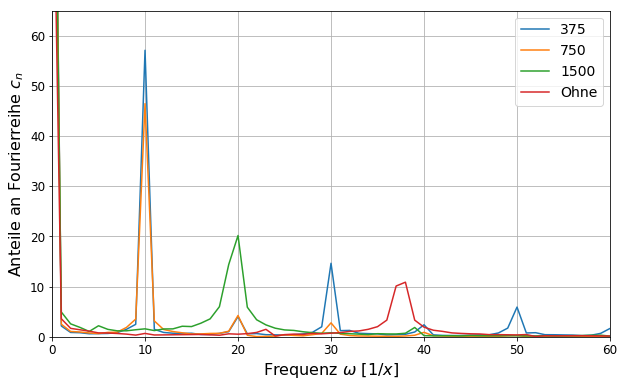

In [261]:
# Diagramm FFT-Linien

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

#for (fftLinie, b) in zip(fftLinien, blende):
    # print(fftLinie)
    #color = next(ax._get_lines.prop_cycler)['color']
for l, k, b in zip([fftLinien[0][i] for i in range(len(fftLinien))], line, blende):
    xdata, ydata = range(len(l)), l
    plt.plot(xdata, ydata, label='%s' % (b))

#xdata, ydata = range(len(fftLinien[0][0])), fftLinien[0][0]
#plt.plot(xdata, ydata, label='GG')

#plt.plot(x, y, label='GG')
#plt.plot(range(len(ffty)), ffty, label='GG')

#xdata, ydata = lamb1, unp.uarray([0.5]*4, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, color='yellow', label='Na-D-Linie 1')

#xdata, ydata = lamb2, unp.uarray([0.5]*4, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, color='orange', label='Na-D-Linie 2')

plt.xlim(0, 60)
plt.ylim(0,65)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
#plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Frequenz $\\omega$ [$1/x$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Anteile an Fourierreihe $c_n$", {'fontsize': fig_legendsize+2})
#plt.yticks([])
plt.savefig("data/FFTLinie1.pdf")
plt.show()

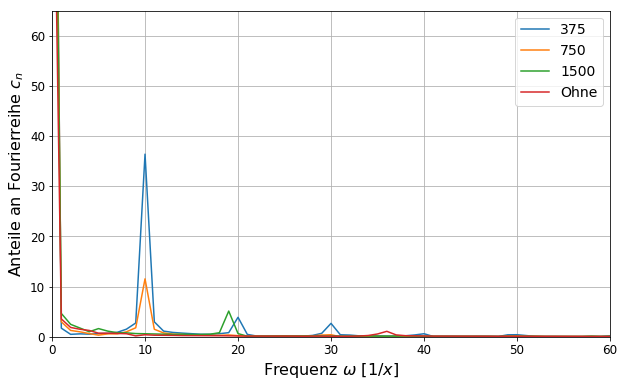

In [262]:
# Diagramm FFT-Linien

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

#for (fftLinie, b) in zip(fftLinien, blende):
    # print(fftLinie)
    #color = next(ax._get_lines.prop_cycler)['color']
for l, k, b in zip([fftLinien[3][i] for i in range(len(fftLinien))], line, blende):
    xdata, ydata = range(len(l)), l
    plt.plot(xdata, ydata, label='%s' % (b))

#xdata, ydata = range(len(fftLinien[0][0])), fftLinien[0][0]
#plt.plot(xdata, ydata, label='GG')

#plt.plot(x, y, label='GG')
#plt.plot(range(len(ffty)), ffty, label='GG')

#xdata, ydata = lamb1, unp.uarray([0.5]*4, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, color='yellow', label='Na-D-Linie 1')

#xdata, ydata = lamb2, unp.uarray([0.5]*4, 0.5)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=1, color='orange', label='Na-D-Linie 2')

plt.xlim(0, 60)
plt.ylim(0,65)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
#plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Frequenz $\\omega$ [$1/x$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Anteile an Fourierreihe $c_n$", {'fontsize': fig_legendsize+2})
#plt.yticks([])
plt.savefig("data/FFTLinie4.pdf")
plt.show()

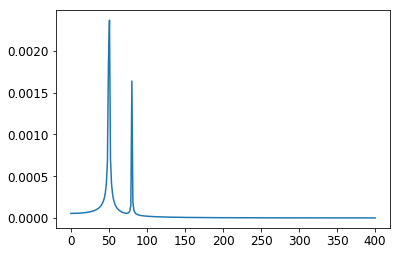

In [263]:
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*math.pi*x) + 0.5*np.sin(80.0 * 2.0*math.pi*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [264]:
# Rechnung sterne

WIDTH = 11
sternData2 = []
for stDat in sternData:
    stDat2 = []
    for s in stDat:
        x, y = s
        ky = []
        xmax = max(x)
        for i in range(len(x)):
            sum = 0
            for j in range(WIDTH):
                sum += y[(i+j-WIDTH//2) % len(x)]
            ky.append(sum)
        ymax = max(ky)
        i = 250
        while ky[i] > 0.5 * ymax:
            i += 1
        hwb1 = x[i]
        i = len(x) - 250
        while ky[i] > 0.5 * ymax:
            i -= 1
        hwb2 = x[i]
        hwb = hwb2 - hwb1
        stDat2.append((hwb, x, np.array(ky)/WIDTH))
    sternData2.append(stDat2)
hwbValue = np.array([sternData2[i][j][0] for i in range(len(sternData2)) for j in range(4)])
latex_printValue(hwbValue*pxratio, "halbwertsBreiten_groesse_linse")
lBreite = math.pi * hwbValue / 36
latex_printValue(lBreite * pxratio, "linienbreiteAufloesung")

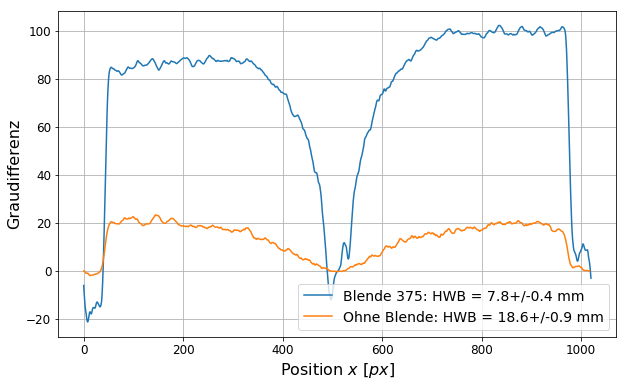

In [265]:
# Diagramm sterne

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

#xdata = np.linspace(-1.1, 1.1)
#plt.plot(xdata, unv(linear(xdata, *magnet)), label='Linear Fit $B=m I$\n$m = (%s)$mT/A' % tuple(magnet))

hwb, xdata, ydata = sternData2[0][0]
plt.plot(unv(xdata), unv(ydata), label='Blende 375: HWB = %s mm' % (hwb*pxratio))

hwb, xdata, ydata = sternData2[0][3]
plt.plot(unv(xdata), unv(ydata), label='Ohne Blende: HWB = %s mm' % (hwb*pxratio))

#xdata, ydata = h*1e9, unp.uarray([0.5]*len(h), 0.45)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, label='Helium')

#xdata, ydata = heAngabe*1e9, unp.uarray([-0.5]*len(heAngabe), 0.45)
#plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, label='Helium-Angabe')

# plt.xlim(400,401)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Position $x$ [$px$]", {'fontsize':fig_legendsize+2})
plt.ylabel("Graudifferenz", {'fontsize': fig_legendsize+2})
#plt.yticks([])
plt.savefig("data/Sterne.pdf")
plt.show()

In [266]:
# Rechnung MTF 1/2

kHalbe2 = []
for (b, data)  in zip(blende, mtfKante):
    for (x,y) in zip(data[0], data[1]):
        if (y >= 0.5):
            d = x
    kHalbe2.append(d)


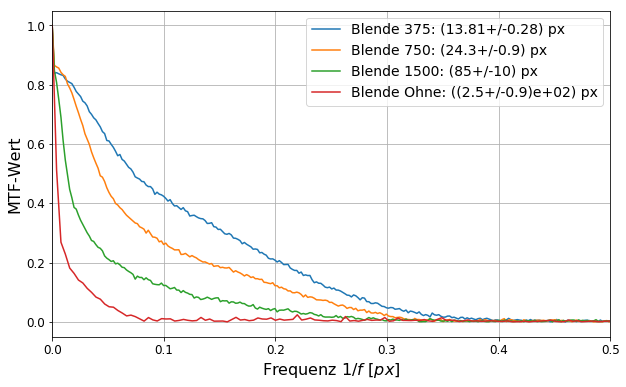

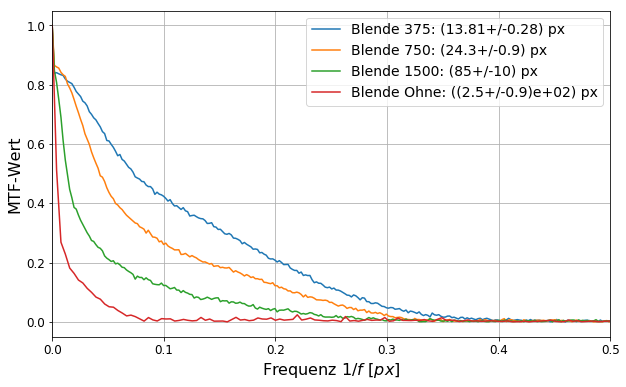

In [273]:
# Diagramm mtfStufen2

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

for (b, data, kH)  in zip(blende, mtfKante, kHalbe2):
    xdata, ydata = data
    plt.plot(unv(xdata), unv(ydata), label='Blende %s: (%s) px'%(b, 1/kH))
    
plt.xlim(0,0.5)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.xlabel("Frequenz $1/f$ [$px$]", {'fontsize':fig_legendsize+2})
plt.ylabel("MTF-Wert", {'fontsize': fig_legendsize+2})
#plt.yticks([])
plt.savefig("data/MTFKanteLinsen.pdf")
plt.show()

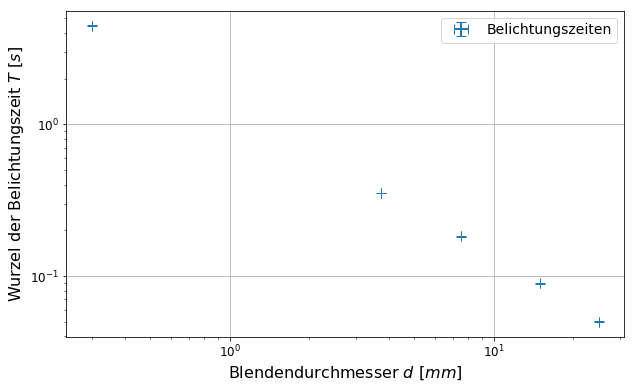

In [268]:
# Diagramm mtfStufen2

fig=plt.figure(figsize=fig_size)
#ax = plt.gca()
#color = next(ax._get_lines.prop_cycler)['color']

xdata, names, ydata = [25, 15, 7.5, 3.75, 0.3], zeitvergleich[0], unp.sqrt(zeitvergleich[1])
plt.errorbar(unv(xdata),unv(ydata),usd(ydata),usd(xdata),fmt=' ', capsize=5, linewidth=2, label='Belichtungszeiten')
 
#plt.xlim(0,0.5)
plt.legend(prop={'size':fig_legendsize})
plt.grid()
plt.tick_params(labelsize=fig_labelsize)
plt.ylabel("Wurzel der Belichtungszeit $T$ [$s$]", {'fontsize':fig_legendsize+2})
plt.xlabel("Blendendurchmesser $d$ [$mm$]", {'fontsize': fig_legendsize+2})
#plt.xticks([])
plt.xscale('log')
plt.yscale('log')
plt.savefig("data/Zeitvergleich.pdf")
plt.show()

In [270]:
# Rechnung Mikroskopaufloesung

f = unc.ufloat(50, 0)
g = unc.ufloat(1020, 4)
pxratio = unc.ufloat(1, 0.05) * 3 / 41
k = np.array(kStufen)/100

DB = umath.sqrt(6016**2 + 4000**2) * pxratio
Z = DB/1500
dh = f**2 / (k*Z) + f
S = g * (dh - f) * (1/(dh-g) - 1/(dh + g - 2 * f))
latex_printValue(S, "schaerfentiefe")
latex_printValue(dh, "hyperfokusLASER")